# 0. Imports

## 0.1. Libraries and configs

In [52]:
# Bult-in
import os
from sys import path
path.append(os.path.join(".."))
from typing import Dict, List

# Installed
from inflection import underscore
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split, cross_validate
from sklearn import preprocessing as pp
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import ExtraTreesRegressor, HistGradientBoostingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn import metrics as m

# Custom
from src.utils import set_jupyter_settings
set_jupyter_settings(filterwarnings=True)
from src.database.data_ingestion import ingest_data_into_database

[03/01/23 21:17:16] INFO     Jupyter has been successfully configured.                                  ]8;id=441001;file:///home/sheep/documents/repos/predict-taxi-tip-amount/notebooks/../src/utils.py\utils.py]8;;\:]8;id=42450;file:///home/sheep/documents/repos/predict-taxi-tip-amount/notebooks/../src/utils.py#57\57]8;;\

In [2]:
CONNECTION_STRING: str | None = os.getenv("CONNECTION_STRING")
DATA_DIR: str = os.path.join("..", "data")
PREPROCESSORS_DIR: str = os.path.join("..", "src", "pipeline", "preprocessors")

## 0.2. Helper functions

In [67]:
def get_metrics(scores: Dict[str, np.ndarray]) -> Dict[str, str]:
    """Convert responses from the scikit-learn model seletion function `cross_validate`
        to human-readable metrics.
    Args:
        scores (dict[str, np.ndarray]): Dictionary containing the metrics scores
            for each iteration over the model.
    """
    return {
        "MAE": np.round(np.abs(np.mean(scores["test_neg_mean_absolute_error"])), 6),
        "RMSE": np.round(np.abs(np.mean(scores["test_neg_root_mean_squared_error"])), 6),
        "MAPE": np.round(np.abs(np.mean(scores["test_neg_mean_absolute_percentage_error"])), 6)
    }

## 0.3. Data acquisition
Data source: [TLC Trip Record Data](https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page)

In [4]:
ingest_data_into_database(
    connection_string=CONNECTION_STRING,
    data_directory=DATA_DIR,
    files=[
        "green_tripdata_2022-01.parquet",
        "green_tripdata_2022-02.parquet",
    ]
)

[03/01/23 09:46:18] INFO     Ingesting 131894 records into the database...                     ]8;id=499748;file:///home/sheep/documents/repos/predict-taxi-tip-amount/notebooks/../src/database/data_ingestion.py\data_ingestion.py]8;;\:]8;id=375441;file:///home/sheep/documents/repos/predict-taxi-tip-amount/notebooks/../src/database/data_ingestion.py#26\26]8;;\

[03/01/23 09:46:49] INFO     Data ingestion completed.                                         ]8;id=146039;file:///home/sheep/documents/repos/predict-taxi-tip-amount/notebooks/../src/database/data_ingestion.py\data_ingestion.py]8;;\:]8;id=295528;file:///home/sheep/documents/repos/predict-taxi-tip-amount/notebooks/../src/database/data_ingestion.py#43\43]8;;\

In [4]:
raw_data: pd.DataFrame = pd.read_sql("SELECT * FROM green_taxi", CONNECTION_STRING)
raw_data.sample(3)

,id,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
105617,105618,2,2022-02-20 11:29:23,2022-02-20 11:45:01,N,1.0,196,173,1.0,1.83,11.5,0.0,0.5,0.00,0.0,None,0.3,12.30,2.0,1.0,0.0
83188,83189,2,2022-02-10 14:14:15,2022-02-10 14:25:47,N,1.0,75,166,1.0,1.76,9.5,0.0,0.5,2.58,0.0,None,0.3,12.88,1.0,1.0,0.0
72941,72942,2,2022-02-05 16:37:49,2022-02-05 16:59:11,N,5.0,82,82,1.0,2.71,15.0,0.0,0.0,0.00,0.0,None,0.3,15.30,2.0,2.0,0.0


# 1. Data cleansing and description

## Data dictionary
Link: [Data dictionary trip records green](https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_green.pdf)

## 1.1. Rename columns

In [5]:
raw_data.columns = [underscore(column) for column in raw_data.columns]

## 1.2. Data dimensions

In [6]:
print(
    f"""
    Number of columns: {raw_data.shape[1]}
    Number of rows: {raw_data.shape[0]:,}
    """
)


    Number of columns: 21
    Number of rows: 131,894
    


## 1.3. Duplicate data

In [7]:
raw_data.duplicated().sum()

0

## 1.4. Data types

In [8]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131894 entries, 0 to 131893
Data columns (total 21 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   id                     131894 non-null  int64         
 1   vendor_id              131894 non-null  object        
 2   lpep_pickup_datetime   131894 non-null  datetime64[ns]
 3   lpep_dropoff_datetime  131894 non-null  datetime64[ns]
 4   store_and_fwd_flag     118178 non-null  object        
 5   ratecode_id            118178 non-null  object        
 6   pu_location_id         131894 non-null  object        
 7   do_location_id         131894 non-null  object        
 8   passenger_count        118178 non-null  float64       
 9   trip_distance          131894 non-null  float64       
 10  fare_amount            131894 non-null  float64       
 11  extra                  131894 non-null  float64       
 12  mta_tax                131894 non-null  floa

## 1.5. Missing data

In [9]:
raw_data.isna().sum()

id                            0
vendor_id                     0
lpep_pickup_datetime          0
lpep_dropoff_datetime         0
store_and_fwd_flag        13716
ratecode_id               13716
pu_location_id                0
do_location_id                0
passenger_count           13716
trip_distance                 0
fare_amount                   0
extra                         0
mta_tax                       0
tip_amount                    0
tolls_amount                  0
ehail_fee                131894
improvement_surcharge         0
total_amount                  0
payment_type              13716
trip_type                 13716
congestion_surcharge      13716
dtype: int64

In [10]:
remove_rows_because_of_null_values: List[str] = [
    "store_and_fwd_flag", "passenger_count",
    "payment_type", "trip_type", "congestion_surcharge"
]
raw_data.dropna(subset=remove_rows_because_of_null_values, axis=0, inplace=True)

## 1.6. Outliers

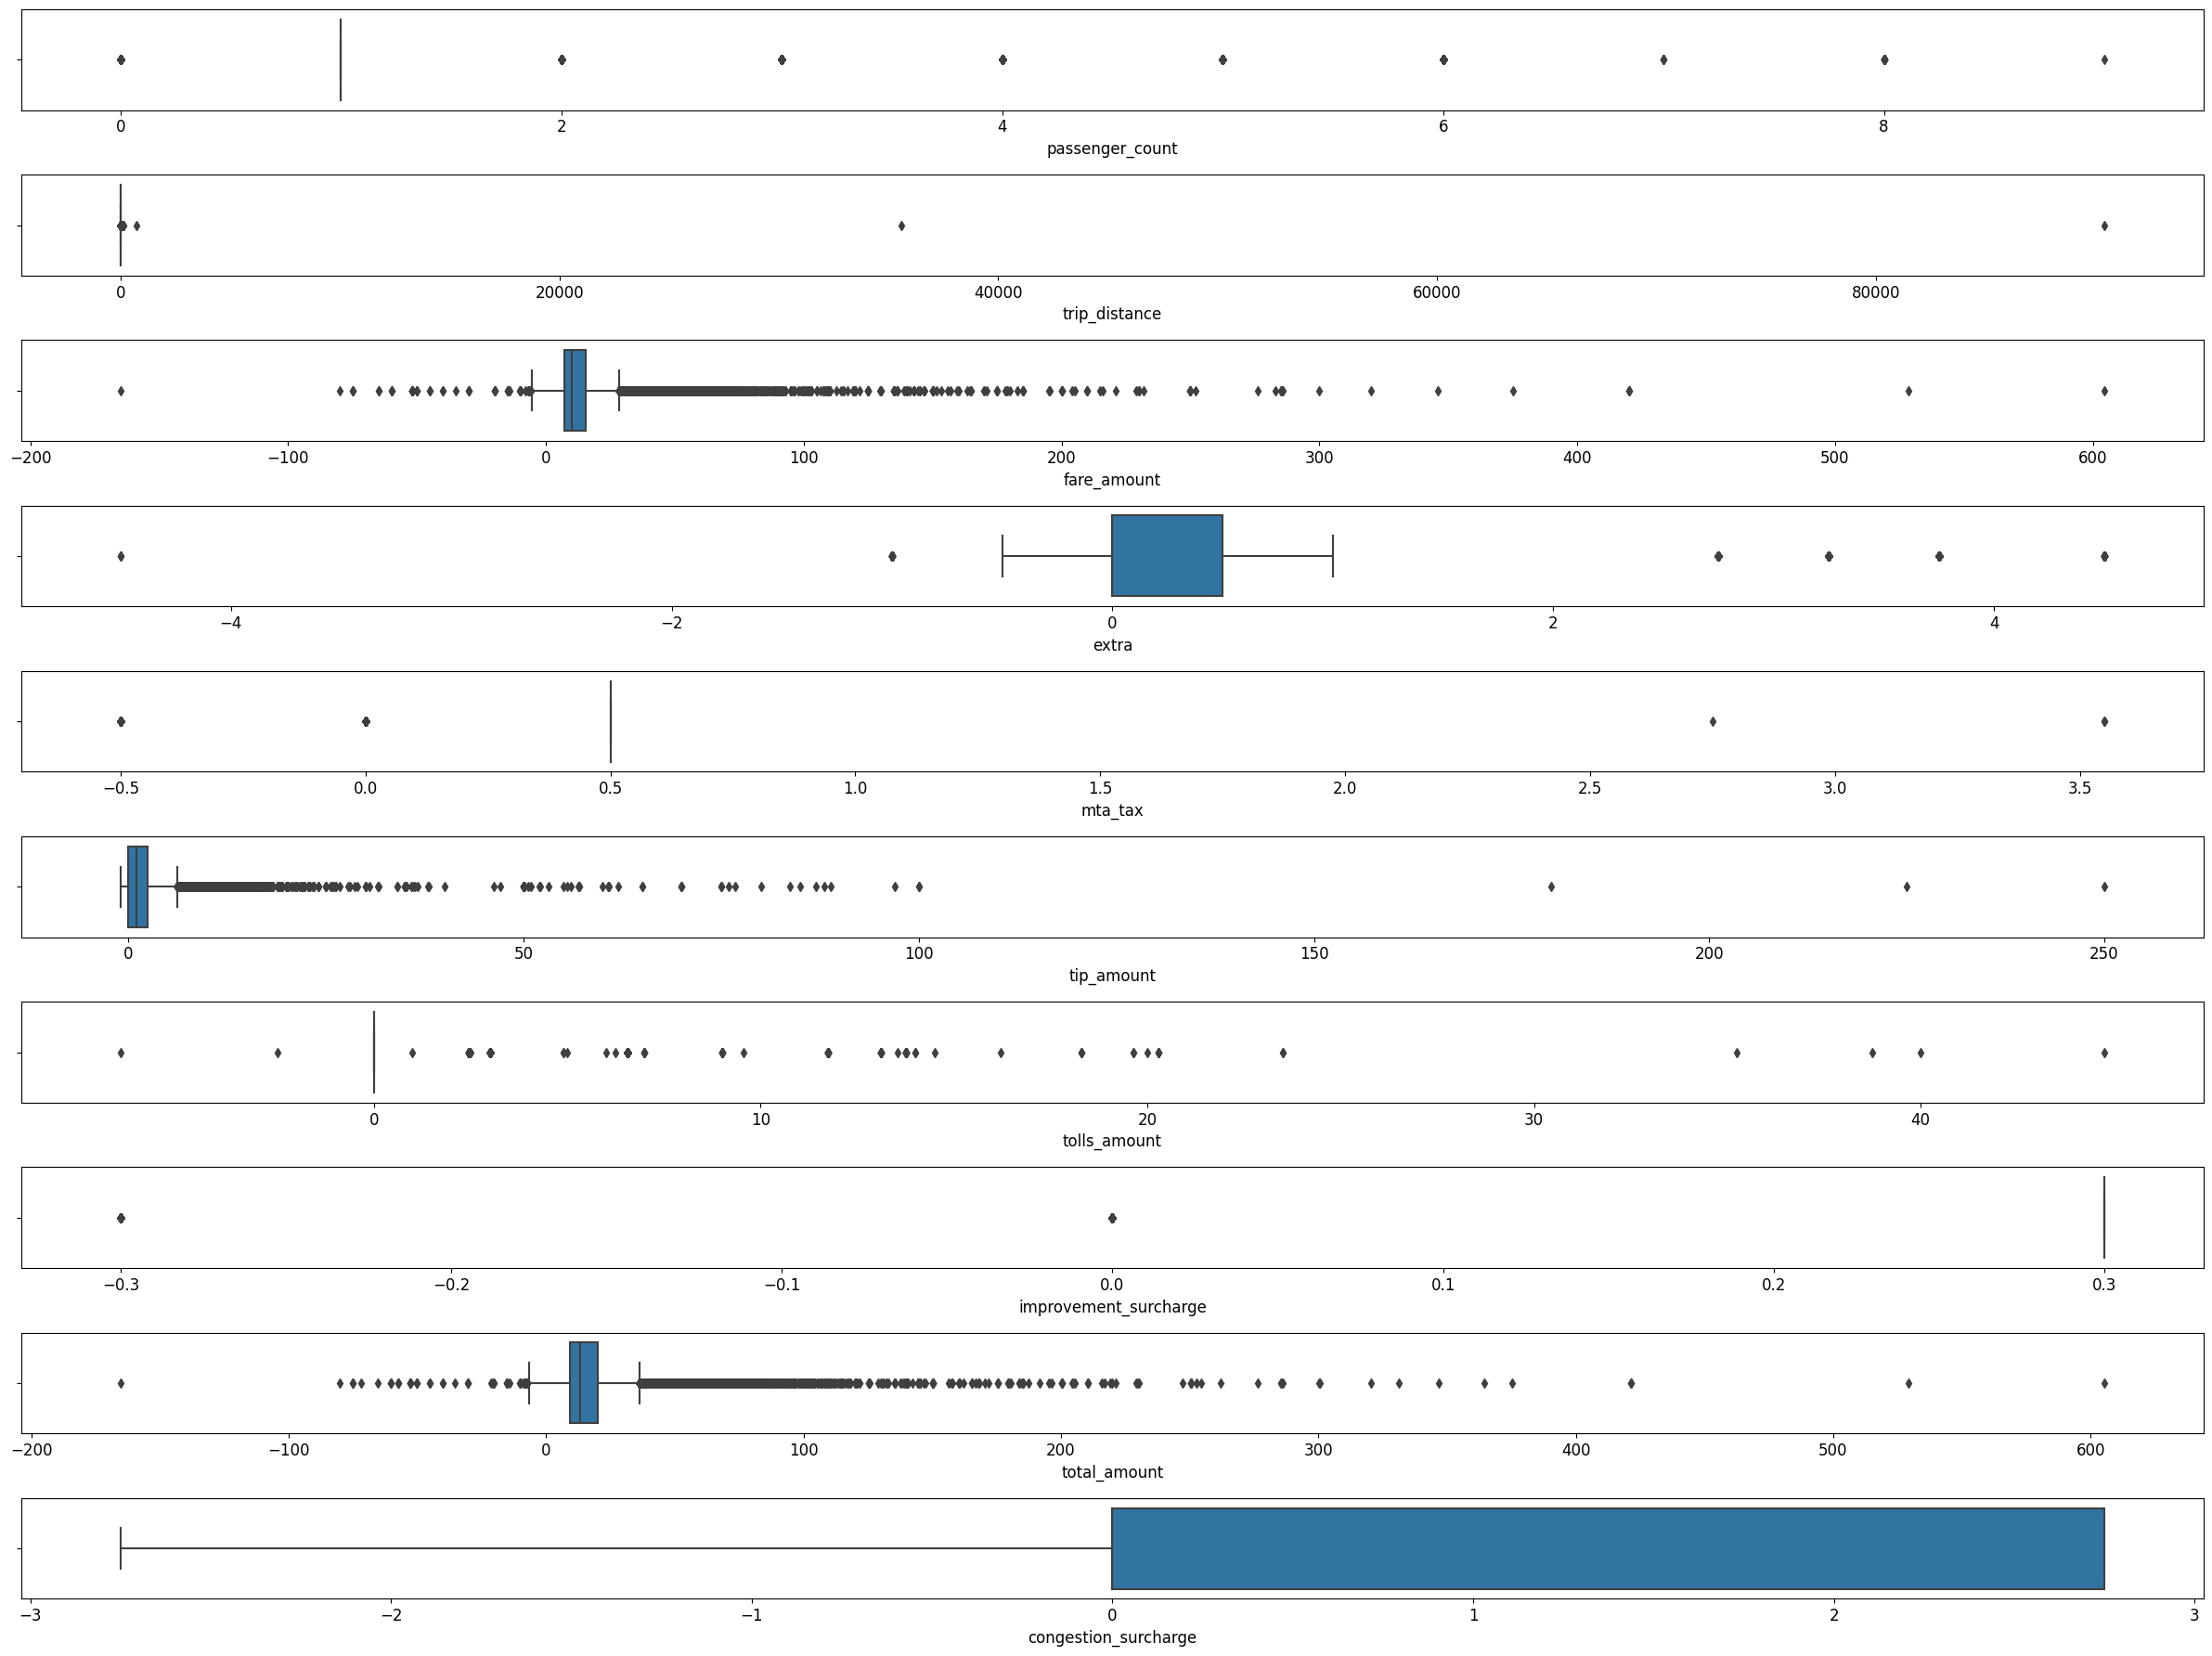

In [11]:
might_have_outlier_columns: List[str] = [
    "passenger_count", "trip_distance", "fare_amount",
    "extra", "mta_tax", "tip_amount", "tolls_amount",
    "improvement_surcharge", "total_amount", "congestion_surcharge"
]
_, ax = plt.subplots(
    nrows=len(might_have_outlier_columns),
    ncols=1,
    figsize=(24,18)
)
for idx, column in enumerate(might_have_outlier_columns):
    sns.boxplot(x=column, data=raw_data, ax=ax[idx]);
    plt.tight_layout()

In [12]:
print(f"Before: {len(raw_data):,}")
for column in might_have_outlier_columns:
    q75, q25 = np.percentile(raw_data.loc[:, column], 75), np.percentile(raw_data.loc[:, column], 25)
    iqr: float = q75 - q25
    cut_off: float = 1.5 * iqr # 1.5 outlier rule
    lower, upper = q25 - cut_off, q75 + cut_off
    mask: List[bool] = [False if x < lower or x > upper else True for x in raw_data.loc[:, column]]
    raw_data: pd.DataFrame = raw_data.loc[mask, :]
print(f"After: {len(raw_data):,}")

Before: 118,178
After: 63,337


## 1.7. Descriptive statistics

In [13]:
numerical_attributes: pd.DataFrame = raw_data.select_dtypes(include=["int", "float"])
categorical_attributes: pd.DataFrame = raw_data.select_dtypes(include=["object", "category"])

### 1.7.1. Numerical attributes

In [14]:
# Calculate central tendency and dispersion metrics
numerical_attributes_description = pd.DataFrame({
    "Mean": numerical_attributes.apply(np.mean),
    "Median": numerical_attributes.apply(np.median),
    "Std. deviation": numerical_attributes.apply(np.std),
    "Min": numerical_attributes.apply(np.min),
    "Max": numerical_attributes.apply(np.max),
    "Range": numerical_attributes.apply(lambda x: np.max(x) - np.min(x)),
    "Skew": numerical_attributes.apply(lambda x: x.skew()),
    "Kurtosis": numerical_attributes.apply(lambda x: x.kurtosis())
})
numerical_attributes_description

,Mean,Median,Std. deviation,Min,Max,Range,Skew,Kurtosis
id,62001.834567,65005.00,3.665450e+04,1.0,124472.00,124471.00,-0.002809,-1.273839
passenger_count,1.000000,1.00,0.000000e+00,1.0,1.00,0.00,0.000000,0.000000
trip_distance,1.721834,1.43,1.190340e+00,0.0,6.43,6.43,1.271246,1.721701
fare_amount,9.188221,8.00,4.251891e+00,0.0,24.00,24.00,1.006917,0.665416
extra,0.302019,0.00,4.098310e-01,0.0,1.00,1.00,0.842958,-0.990026
mta_tax,0.500000,0.50,0.000000e+00,0.5,0.50,0.00,0.000000,0.000000
tip_amount,0.992139,0.00,1.241929e+00,0.0,5.75,5.75,1.019500,0.238969
tolls_amount,0.000000,0.00,0.000000e+00,0.0,0.00,0.00,0.000000,0.000000
improvement_surcharge,0.300000,0.30,5.551115e-17,0.3,0.30,0.00,0.000000,0.000000
total_amount,11.282842,10.30,4.629831e+00,0.8,28.00,27.20,0.850760,0.386300


### 1.7.2. Categorical attributes

In [15]:
categorical_attributes.describe().T

,count,unique,top,freq
vendor_id,63337,2,2,53313
store_and_fwd_flag,63337,2,N,62650
ratecode_id,63337,5,1.0,63257
pu_location_id,63337,185,74,11394
do_location_id,63337,217,74,5410
ehail_fee,0,0,NaN,NaN
payment_type,63337,4,1.0,35122
trip_type,63337,2,1.0,63326


# 2. Feature engineering

## 2.1. Phenomenon modeling

In [16]:
# Create new columns using the shorthand pandas function "assign"
raw_data: pd.DataFrame = raw_data.assign(
    trip_duration=(
        raw_data.loc[:, "lpep_dropoff_datetime"] - raw_data.loc[:, "lpep_pickup_datetime"]
    ).dt.seconds / 60,
    pickup_second=(
        raw_data.loc[:, "lpep_pickup_datetime"].dt.second
    ),
    pickup_minute=(
        raw_data.loc[:, "lpep_pickup_datetime"].dt.minute
    ),
    pickup_hour=(
        raw_data.loc[:, "lpep_pickup_datetime"].dt.hour
    ),
    dropoff_second=(
        raw_data.loc[:, "lpep_dropoff_datetime"].dt.second
    ),
    dropoff_minute=(
        raw_data.loc[:, "lpep_dropoff_datetime"].dt.minute
    ),
    dropoff_hour=(
        raw_data.loc[:, "lpep_dropoff_datetime"].dt.hour
    ),
    dropoff_day=(
        raw_data.loc[:, "lpep_dropoff_datetime"].dt.day
    ),
    dropoff_week=(
        raw_data.loc[:, "lpep_dropoff_datetime"].dt.week
    ),
    dropoff_weekofyear=(
        raw_data.loc[:, "lpep_dropoff_datetime"].dt.weekofyear
    ),
    location_id=(
        raw_data.loc[:, "pu_location_id"] + raw_data.loc[:, "do_location_id"]
    ),
    price_per_meter=(
        raw_data.loc[:, "trip_distance"] / (raw_data.loc[:, "fare_amount"] + 1)
    ),
    tax_per_meter=(
        raw_data.loc[:, "trip_distance"] * raw_data.loc[:, "mta_tax"]
    ),
)

## 2.2. Filtering

In [17]:
irrelevant_columns_to_drop: List[str] = [
    "ehail_fee", "passenger_count", "tolls_amount",
    "improvement_surcharge", "congestion_surcharge"
]
raw_data.drop(irrelevant_columns_to_drop, axis=1, inplace=True)

In [18]:
raw_data = raw_data.loc[(raw_data.loc[:, "trip_duration"] >= 1) & (raw_data.loc[:, "trip_duration"] <= 60), :]

## Checkpoint

In [19]:
CHECKPOINT_DIR: str = os.path.join(DATA_DIR, "interim", "cleaned_train_data.parquet")
raw_data.to_parquet(CHECKPOINT_DIR)
del raw_data # Remove dirty data from memory

In [20]:
df: pd.DataFrame = pd.read_parquet(CHECKPOINT_DIR)
df.sample(3)

,id,vendor_id,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,ratecode_id,pu_location_id,do_location_id,trip_distance,fare_amount,extra,mta_tax,tip_amount,total_amount,payment_type,trip_type,trip_duration,pickup_second,pickup_minute,pickup_hour,dropoff_second,dropoff_minute,dropoff_hour,dropoff_day,dropoff_week,dropoff_weekofyear,location_id,price_per_meter,tax_per_meter
50479,50480,2,2022-01-27 21:37:19,2022-01-27 21:44:24,N,1.0,74,24,1.62,7.0,0.5,0.5,0.00,8.30,2.0,1.0,7.083333,19,37,21,24,44,21,27,4,4,7424,0.202500,0.81
1819,1820,2,2022-01-02 15:59:39,2022-01-02 16:07:34,N,1.0,74,74,1.42,7.5,0.0,0.5,0.83,9.13,1.0,1.0,7.916667,39,59,15,34,7,16,2,52,52,7474,0.167059,0.71
38865,38866,1,2022-01-21 23:40:55,2022-01-21 23:48:35,N,1.0,95,95,1.20,7.0,0.5,0.5,2.00,10.30,1.0,1.0,7.666667,55,40,23,35,48,23,21,3,3,9595,0.150000,0.60


# 3. Exploratory data analysis

## 3.1. Univariate analysis

### 3.1.1. Target variable

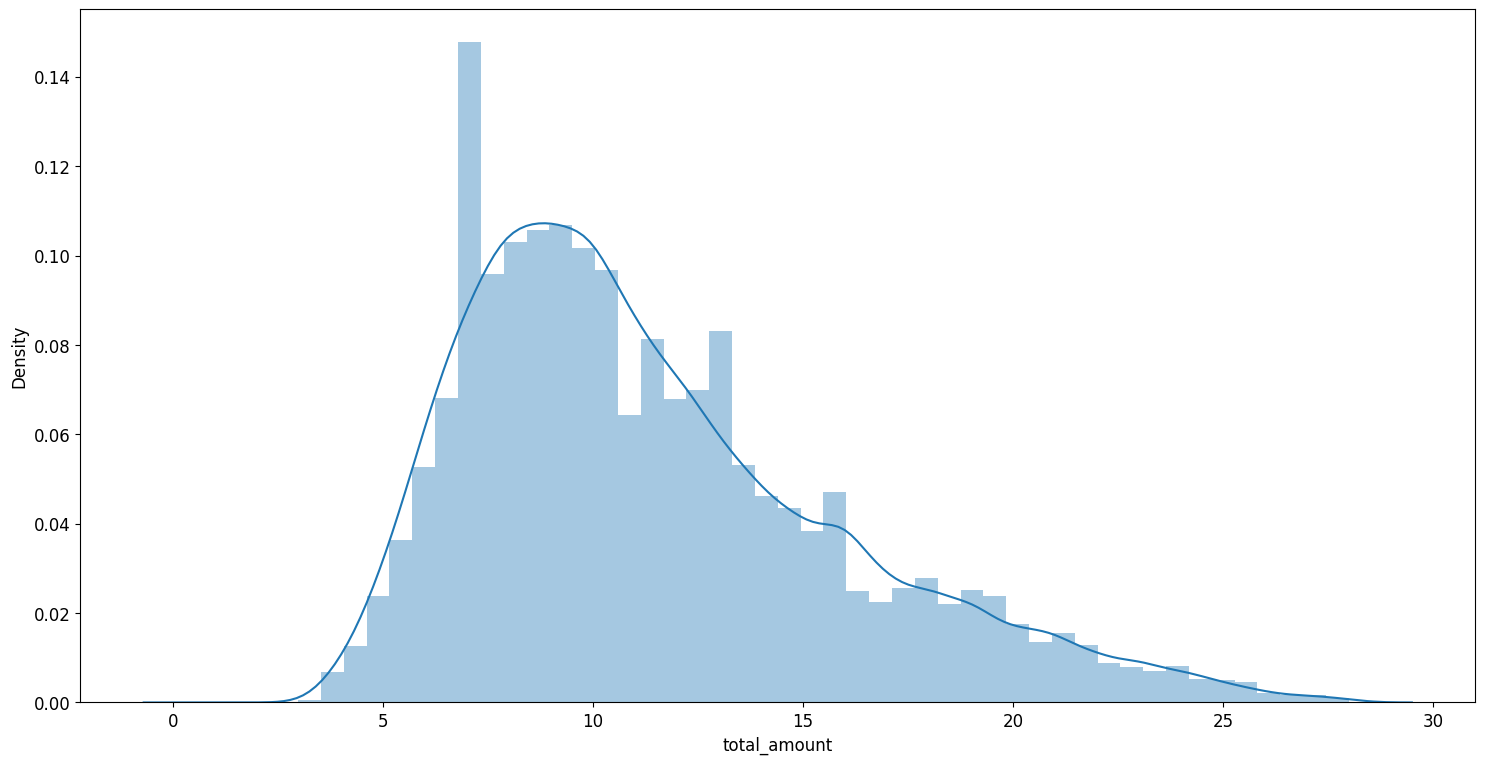

In [21]:
sns.distplot(df.loc[:, "total_amount"]);

### 3.1.2. Numerical variables

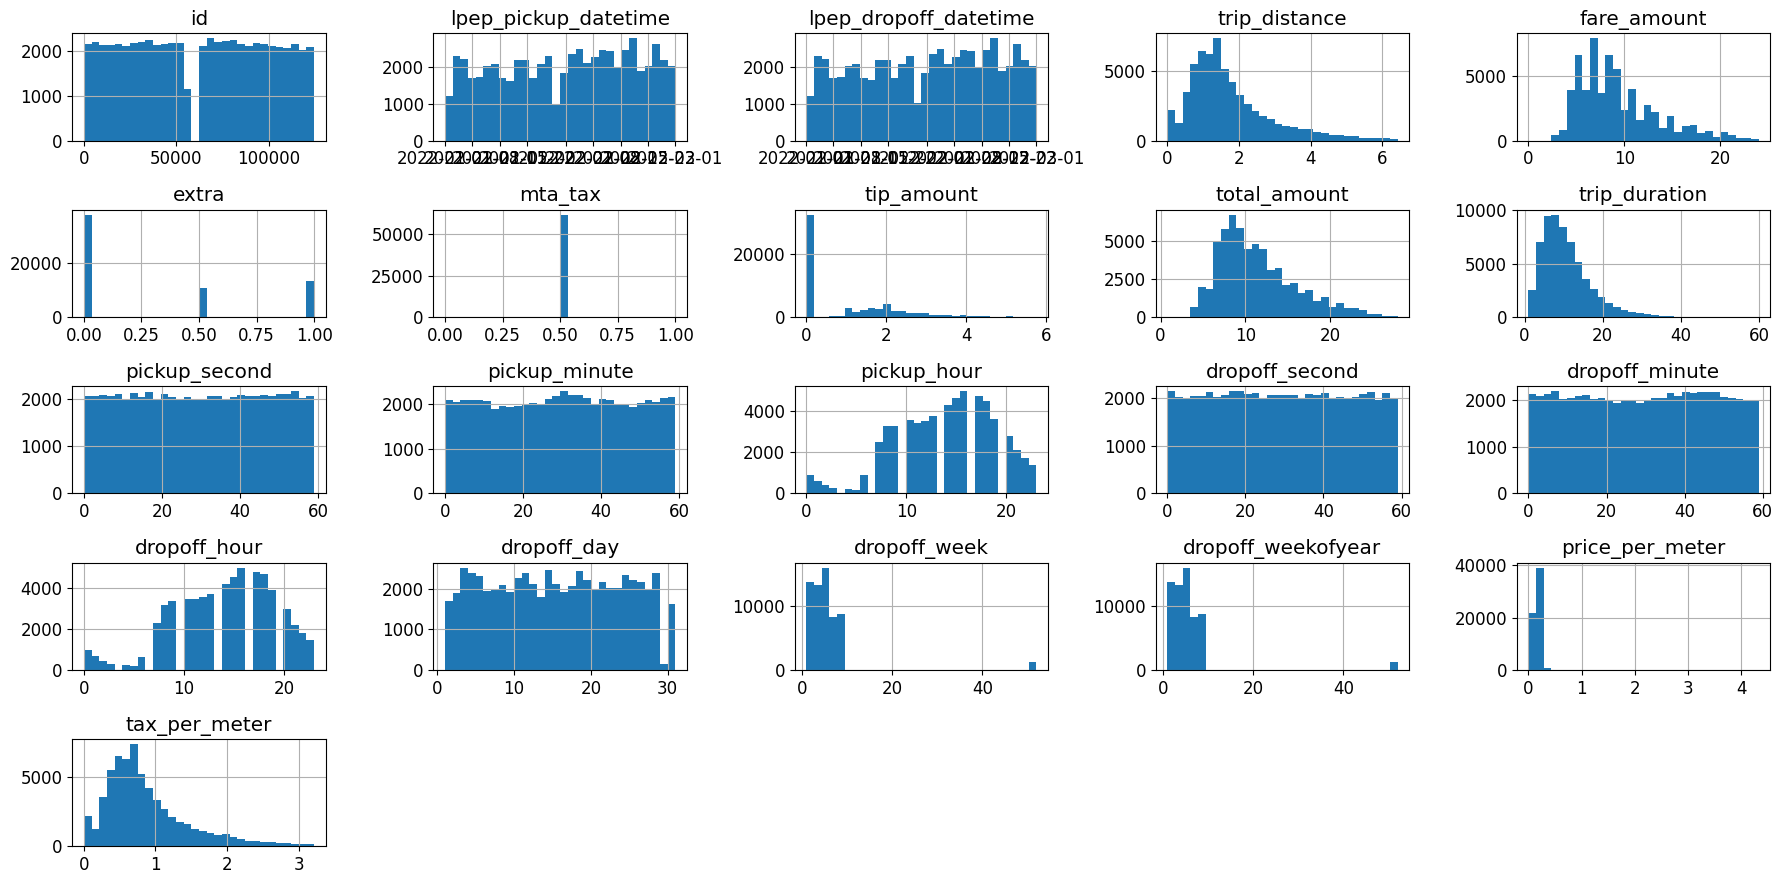

In [22]:
df.hist(bins=30);
plt.tight_layout()

### 3.1.3. Categorical variables

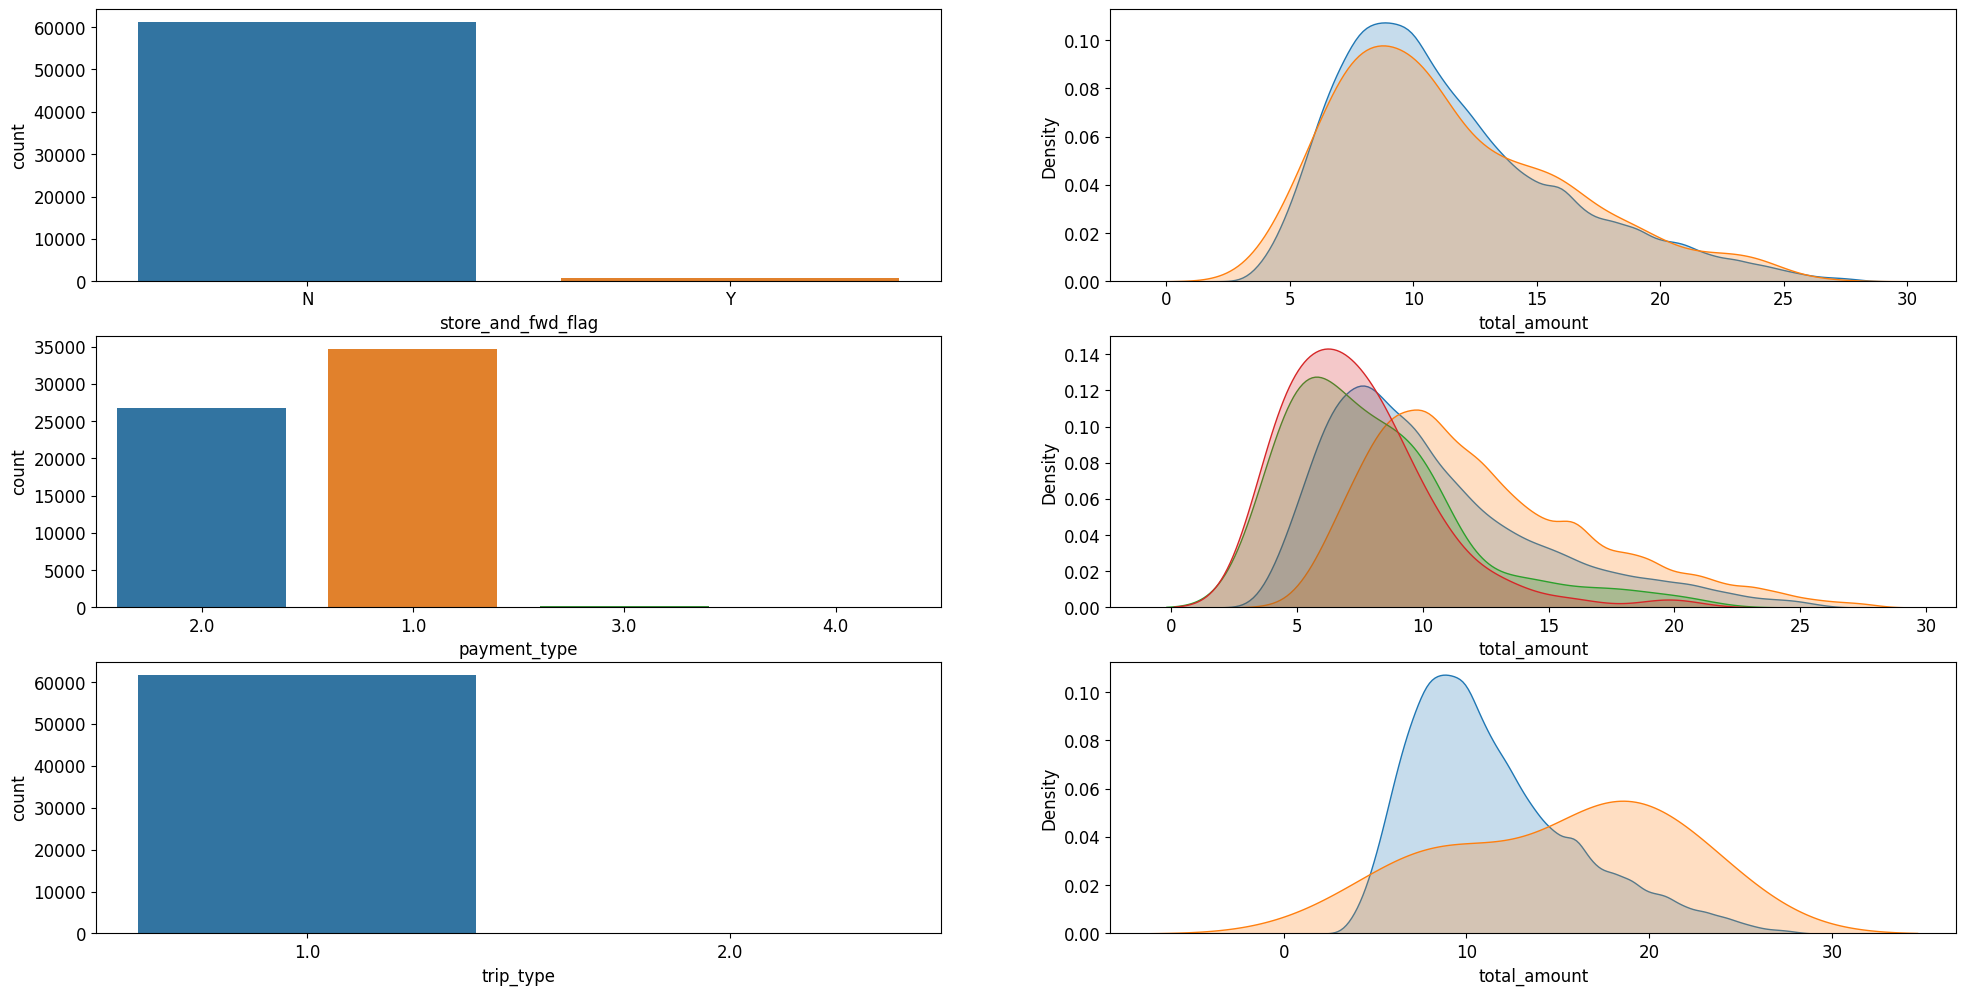

In [23]:
_, ax = plt.subplots(nrows=3, ncols=2, figsize=(24,12))
for idx, column in enumerate(["store_and_fwd_flag", "payment_type", "trip_type"]):
    sns.countplot(x=column, data=df, ax=ax[idx][0]);
    for category in df.loc[:, column].unique():
        sns.kdeplot(
            x="total_amount",
            data=df.loc[df.loc[:, column] == category, :],
            label=category,
            shade=True,
            ax=ax[idx][1]
        );

## 3.2. Bivariate analysis

## 3.3. Multivariate analysis

### 3.3.1. Numerical variables

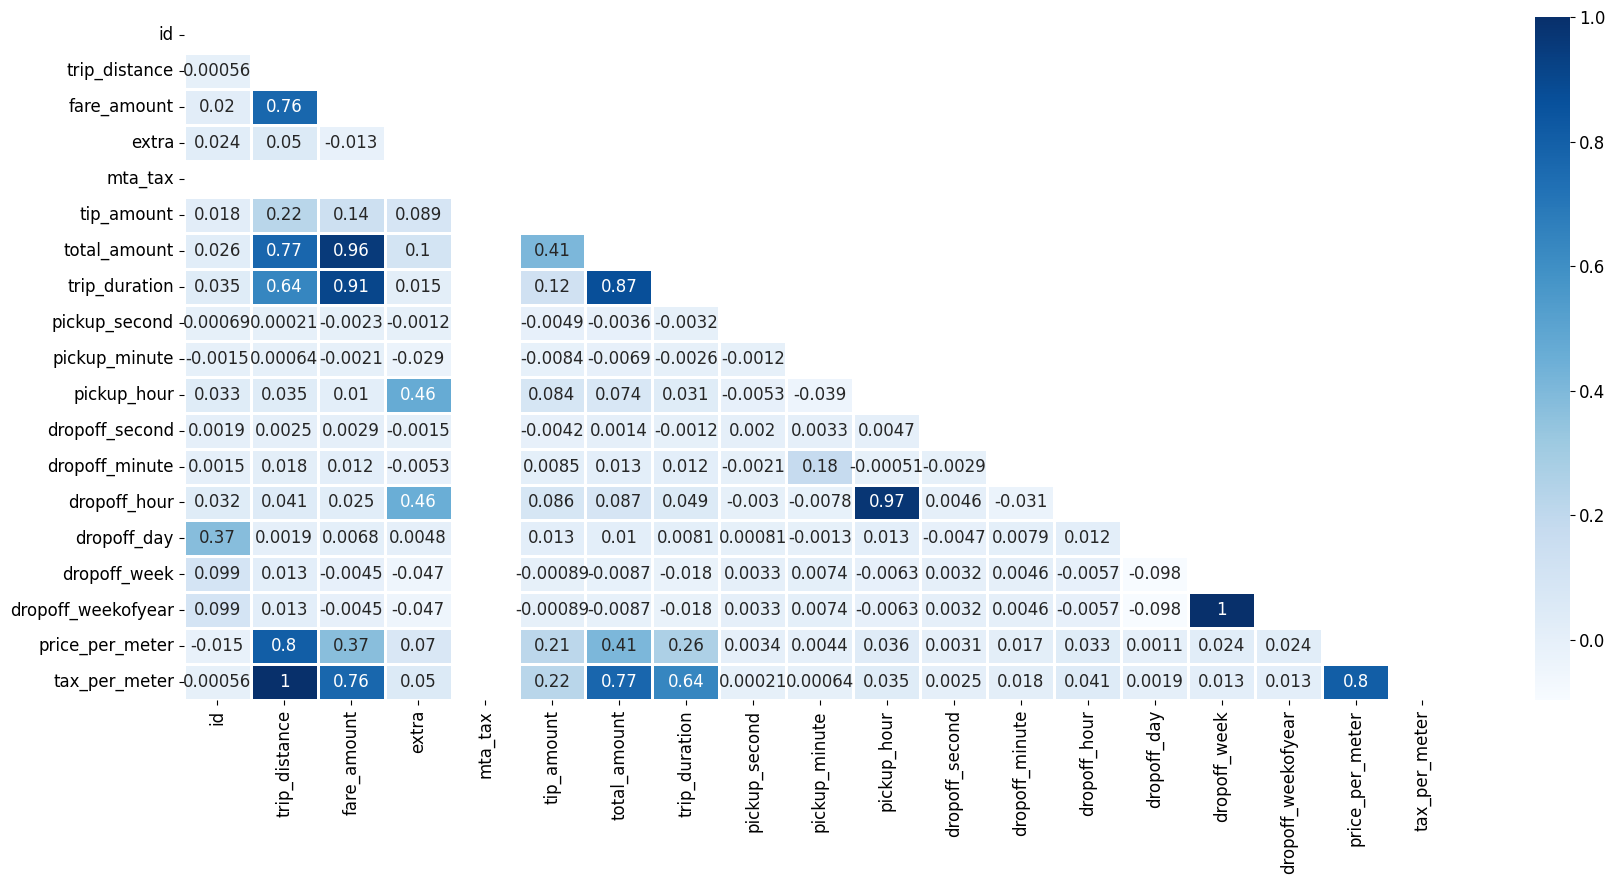

In [24]:
# Compute the correlation matrix
numerical_correlations = df.select_dtypes(include=["int", "float"]).corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(numerical_correlations, dtype=bool))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(
    numerical_correlations,
    mask=mask,
    cmap="Blues",
    annot=True,
    linewidths=2
);
plt.tight_layout()

# 4. Data preprocessing

## 4.1. Data split

In [25]:
X = df.drop("total_amount", axis=1)
y = df.loc[:, "total_amount"]
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    shuffle=True,
)

# Assert splited data dimensions
assert X_train.shape[0] == y_train.shape[0]
assert X_val.shape[0] == y_val.shape[0]

## 4.2. Standardization

In [26]:
columns_to_standardize: List[str] = [
    "trip_distance", "fare_amount", "tip_amount",
    "price_per_meter", "trip_duration", "tax_per_meter",
]
for column in columns_to_standardize:
    standard_scaler = pp.StandardScaler()
    X_train.loc[:, [column]] = standard_scaler.fit_transform(X_train.loc[:, [column]])
    X_val.loc[:, [column]] = standard_scaler.transform(X_val.loc[:, [column]])
    joblib.dump(
        standard_scaler,
        os.path.join(
            PREPROCESSORS_DIR,
            "standard_scaler",
            f"{column}.joblib"
        )
    )

## 4.3. Rescale

### 4.3.1. RobustScaler

In [27]:
columns_to_rescale: List[str] =  ["extra", "mta_tax", "tip_amount"]
for column in columns_to_rescale:
    robust_scaler = pp.RobustScaler()
    X_train.loc[:, [column]] = robust_scaler.fit_transform(X_train.loc[:, [column]])
    X_val.loc[:, [column]] = robust_scaler.transform(X_val.loc[:, [column]])
    joblib.dump(
        robust_scaler,
        os.path.join(
            PREPROCESSORS_DIR,
            "robust_scaler",
            f"{column}.joblib"
        )
    )

## 4.4. Encoding

### 4.4.1. One-hot encoding

In [28]:
columns_to_one_hot_encode: List[str] = [
    "vendor_id",
    "store_and_fwd_flag",
    "ratecode_id",
    "payment_type",
    "trip_type",
]
X_train = pd.get_dummies(X_train, columns=columns_to_one_hot_encode, drop_first=True)
X_val = pd.get_dummies(X_val, columns=columns_to_one_hot_encode, drop_first=True)

### 4.4.2. Frequency encoding

In [29]:
columns_to_frequency_encode: List[str] = [
    "pu_location_id",
    "do_location_id",
    "location_id"
]
for column in columns_to_frequency_encode:
    column_frequency: pd.Series = X_train.groupby(column).size() / len(X_train)
    X_train.loc[:, column] = X_train.loc[:, column].map(column_frequency)
    X_val.loc[:, column] = X_val.loc[:, column].map(column_frequency)

## 4.5. Transformation

### 4.5.1. Nature transformation
References:
- [NVidia developer blog](https://developer.nvidia.com/blog/three-approaches-to-encoding-time-information-as-features-for-ml-models/)
- [Kaggle notebook](https://www.kaggle.com/code/avanwyk/encoding-cyclical-features-for-deep-learning)

In [30]:
# Create a respective sin and cosine for cyclical feature
X_train: pd.DataFrame = X_train.assign(
    pickup_second_sin=(
        X_train.loc[:, "pickup_second"].apply(lambda x: np.sin(x * (2.0 * np.pi / 60)))
    ),
    pickup_second_cos=(
        X_train.loc[:, "pickup_second"].apply(lambda x: np.cos(x * (2.0 * np.pi / 60)))
    ),
    pickup_minute_sin=(
        X_train.loc[:, "pickup_minute"].apply(lambda x: np.sin(x * (2.0 * np.pi / 60)))
    ),
    pickup_minute_cos=(
        X_train.loc[:, "pickup_minute"].apply(lambda x: np.cos(x * (2.0 * np.pi / 60)))
    ),
    pickup_hour_sin=(
        X_train.loc[:, "pickup_hour"].apply(lambda x: np.sin(x * (2.0 * np.pi / 24)))
    ),
    pickup_hour_cos=(
        X_train.loc[:, "pickup_hour"].apply(lambda x: np.cos(x * (2.0 * np.pi / 24)))
    ),
    dropoff_second_sin=(
        X_train.loc[:, "dropoff_second"].apply(lambda x: np.sin(x * (2.0 * np.pi / 60)))
    ),
    dropoff_second_cos=(
        X_train.loc[:, "dropoff_second"].apply(lambda x: np.cos(x * (2.0 * np.pi / 60)))
    ),
    dropoff_minute_sin=(
        X_train.loc[:, "dropoff_minute"].apply(lambda x: np.sin(x * (2.0 * np.pi / 60)))
    ),
    dropoff_minute_cos=(
        X_train.loc[:, "dropoff_minute"].apply(lambda x: np.cos(x * (2.0 * np.pi / 60)))
    ),
    dropoff_hour_sin=(
        X_train.loc[:, "dropoff_hour"].apply(lambda x: np.sin(x * (2.0 * np.pi / 24)))
    ),
    dropoff_hour_cos=(
        X_train.loc[:, "dropoff_hour"].apply(lambda x: np.cos(x * (2.0 * np.pi / 24)))
    ),
    dropoff_day_sin=(
        X_train.loc[:, "dropoff_day"].apply(lambda x: np.sin(x * (2.0 * np.pi / 30)))
    ),
    dropoff_day_cos=(
        X_train.loc[:, "dropoff_day"].apply(lambda x: np.cos(x * (2.0 * np.pi / 30)))
    ),
    dropoff_week_sin=(
        X_train.loc[:, "dropoff_week"].apply(lambda x: np.sin(x * (2.0 * np.pi / 7)))
    ),
    dropoff_week_cos=(
        X_train.loc[:, "dropoff_week"].apply(lambda x: np.cos(x * (2.0 * np.pi / 7)))
    ),
    dropoff_weekofyear_sin=(
        X_train.loc[:, "dropoff_weekofyear"].apply(lambda x: np.sin(x * (2.0 * np.pi / 52)))
    ),
    dropoff_weekofyear_cos=(
        X_train.loc[:, "dropoff_weekofyear"].apply(lambda x: np.cos(x * (2.0 * np.pi / 52)))
    )
)
X_val: pd.DataFrame = X_val.assign(
    pickup_second_sin=(
        X_val.loc[:, "pickup_second"].apply(lambda x: np.sin(x * (2.0 * np.pi / 60)))
    ),
    pickup_second_cos=(
        X_val.loc[:, "pickup_second"].apply(lambda x: np.cos(x * (2.0 * np.pi / 60)))
    ),
    pickup_minute_sin=(
        X_val.loc[:, "pickup_minute"].apply(lambda x: np.sin(x * (2.0 * np.pi / 60)))
    ),
    pickup_minute_cos=(
        X_val.loc[:, "pickup_minute"].apply(lambda x: np.cos(x * (2.0 * np.pi / 60)))
    ),
    pickup_hour_sin=(
        X_val.loc[:, "pickup_hour"].apply(lambda x: np.sin(x * (2.0 * np.pi / 24)))
    ),
    pickup_hour_cos=(
        X_val.loc[:, "pickup_hour"].apply(lambda x: np.cos(x * (2.0 * np.pi / 24)))
    ),
    dropoff_second_sin=(
        X_val.loc[:, "dropoff_second"].apply(lambda x: np.sin(x * (2.0 * np.pi / 60)))
    ),
    dropoff_second_cos=(
        X_val.loc[:, "dropoff_second"].apply(lambda x: np.cos(x * (2.0 * np.pi / 60)))
    ),
    dropoff_minute_sin=(
        X_val.loc[:, "dropoff_minute"].apply(lambda x: np.sin(x * (2.0 * np.pi / 60)))
    ),
    dropoff_minute_cos=(
        X_val.loc[:, "dropoff_minute"].apply(lambda x: np.cos(x * (2.0 * np.pi / 60)))
    ),
    dropoff_hour_sin=(
        X_val.loc[:, "dropoff_hour"].apply(lambda x: np.sin(x * (2.0 * np.pi / 24)))
    ),
    dropoff_hour_cos=(
        X_val.loc[:, "dropoff_hour"].apply(lambda x: np.cos(x * (2.0 * np.pi / 24)))
    ),
    dropoff_day_sin=(
        X_val.loc[:, "dropoff_day"].apply(lambda x: np.sin(x * (2.0 * np.pi / 30)))
    ),
    dropoff_day_cos=(
        X_val.loc[:, "dropoff_day"].apply(lambda x: np.cos(x * (2.0 * np.pi / 30)))
    ),
    dropoff_week_sin=(
        X_val.loc[:, "dropoff_week"].apply(lambda x: np.sin(x * (2.0 * np.pi / 7)))
    ),
    dropoff_week_cos=(
        X_val.loc[:, "dropoff_week"].apply(lambda x: np.cos(x * (2.0 * np.pi / 7)))
    ),
    dropoff_weekofyear_sin=(
        X_val.loc[:, "dropoff_weekofyear"].apply(lambda x: np.sin(x * (2.0 * np.pi / 52)))
    ),
    dropoff_weekofyear_cos=(
        X_val.loc[:, "dropoff_weekofyear"].apply(lambda x: np.cos(x * (2.0 * np.pi / 52)))
    )
)

In [31]:
# Check it out
X_train.sample(3)

,id,lpep_pickup_datetime,lpep_dropoff_datetime,pu_location_id,do_location_id,trip_distance,fare_amount,extra,mta_tax,tip_amount,trip_duration,pickup_second,pickup_minute,pickup_hour,dropoff_second,dropoff_minute,dropoff_hour,dropoff_day,dropoff_week,dropoff_weekofyear,location_id,price_per_meter,tax_per_meter,vendor_id_2,store_and_fwd_flag_Y,ratecode_id_4.0,ratecode_id_5.0,payment_type_2.0,payment_type_3.0,payment_type_4.0,trip_type_2.0,pickup_second_sin,pickup_second_cos,pickup_minute_sin,pickup_minute_cos,pickup_hour_sin,pickup_hour_cos,dropoff_second_sin,dropoff_second_cos,dropoff_minute_sin,dropoff_minute_cos,dropoff_hour_sin,dropoff_hour_cos,dropoff_day_sin,dropoff_day_cos,dropoff_week_sin,dropoff_week_cos,dropoff_weekofyear_sin,dropoff_weekofyear_cos
97141,97142,2022-02-16 17:59:44,2022-02-16 18:13:59,0.090983,0.005059,0.811098,0.647693,2.0,0.0,1.403061,0.585885,44,59,17,59,13,18,16,7,7,0.000688,0.785293,0.811098,0,0,0,0,0,0,0,0,-0.994522,-0.104528,-0.104528,0.994522,-0.965926,-0.258819,-0.104528,0.994522,0.978148,0.207912,-1.0,-1.836970e-16,-0.207912,-0.978148,-2.449294e-16,1.000000,0.748511,0.663123
34911,34912,2022-01-20 09:59:50,2022-01-20 10:08:12,0.062308,0.002347,-0.245280,-0.430985,0.0,0.0,0.632653,-0.363161,50,59,9,12,8,10,20,3,3,0.001821,0.181542,-0.245280,1,0,0,0,0,0,0,0,-0.866025,0.500000,-0.104528,0.994522,0.707107,-0.707107,0.951057,0.309017,0.743145,0.669131,0.5,-8.660254e-01,-0.866025,-0.500000,4.338837e-01,-0.900969,0.354605,0.935016
85447,85448,2022-02-11 13:55:08,2022-02-11 14:02:50,0.180448,0.076696,-0.211204,-0.430985,0.0,0.0,0.000000,-0.470702,8,55,13,50,2,14,11,6,6,0.038571,0.260623,-0.211204,0,0,0,0,1,0,0,0,0.743145,0.669131,-0.500000,0.866025,-0.258819,-0.965926,-0.866025,0.500000,0.207912,0.978148,-0.5,-8.660254e-01,0.743145,-0.669131,-7.818315e-01,0.623490,0.663123,0.748511


# 5. Feature selection

In [32]:
columns_derivated_to_drop: List[str] = [
    "lpep_pickup_datetime", "lpep_dropoff_datetime",
    "pickup_second", "pickup_minute", "pickup_hour",
    "dropoff_second", "dropoff_minute", "dropoff_hour",
    "dropoff_day", "dropoff_week", "dropoff_weekofyear"
]
X_train.drop(columns_derivated_to_drop, axis=1, inplace=True)
X_val.drop(columns_derivated_to_drop, axis=1, inplace=True)

In [33]:
# Classifier that will be used in both feature selection techniques
xtrees_classifier = ExtraTreesRegressor()
xtrees_classifier.fit(
    X_train.drop("id", axis=1).to_numpy(),
    y_train.to_numpy(),
)

ExtraTreesRegressor()

## 5.1. Feature importance

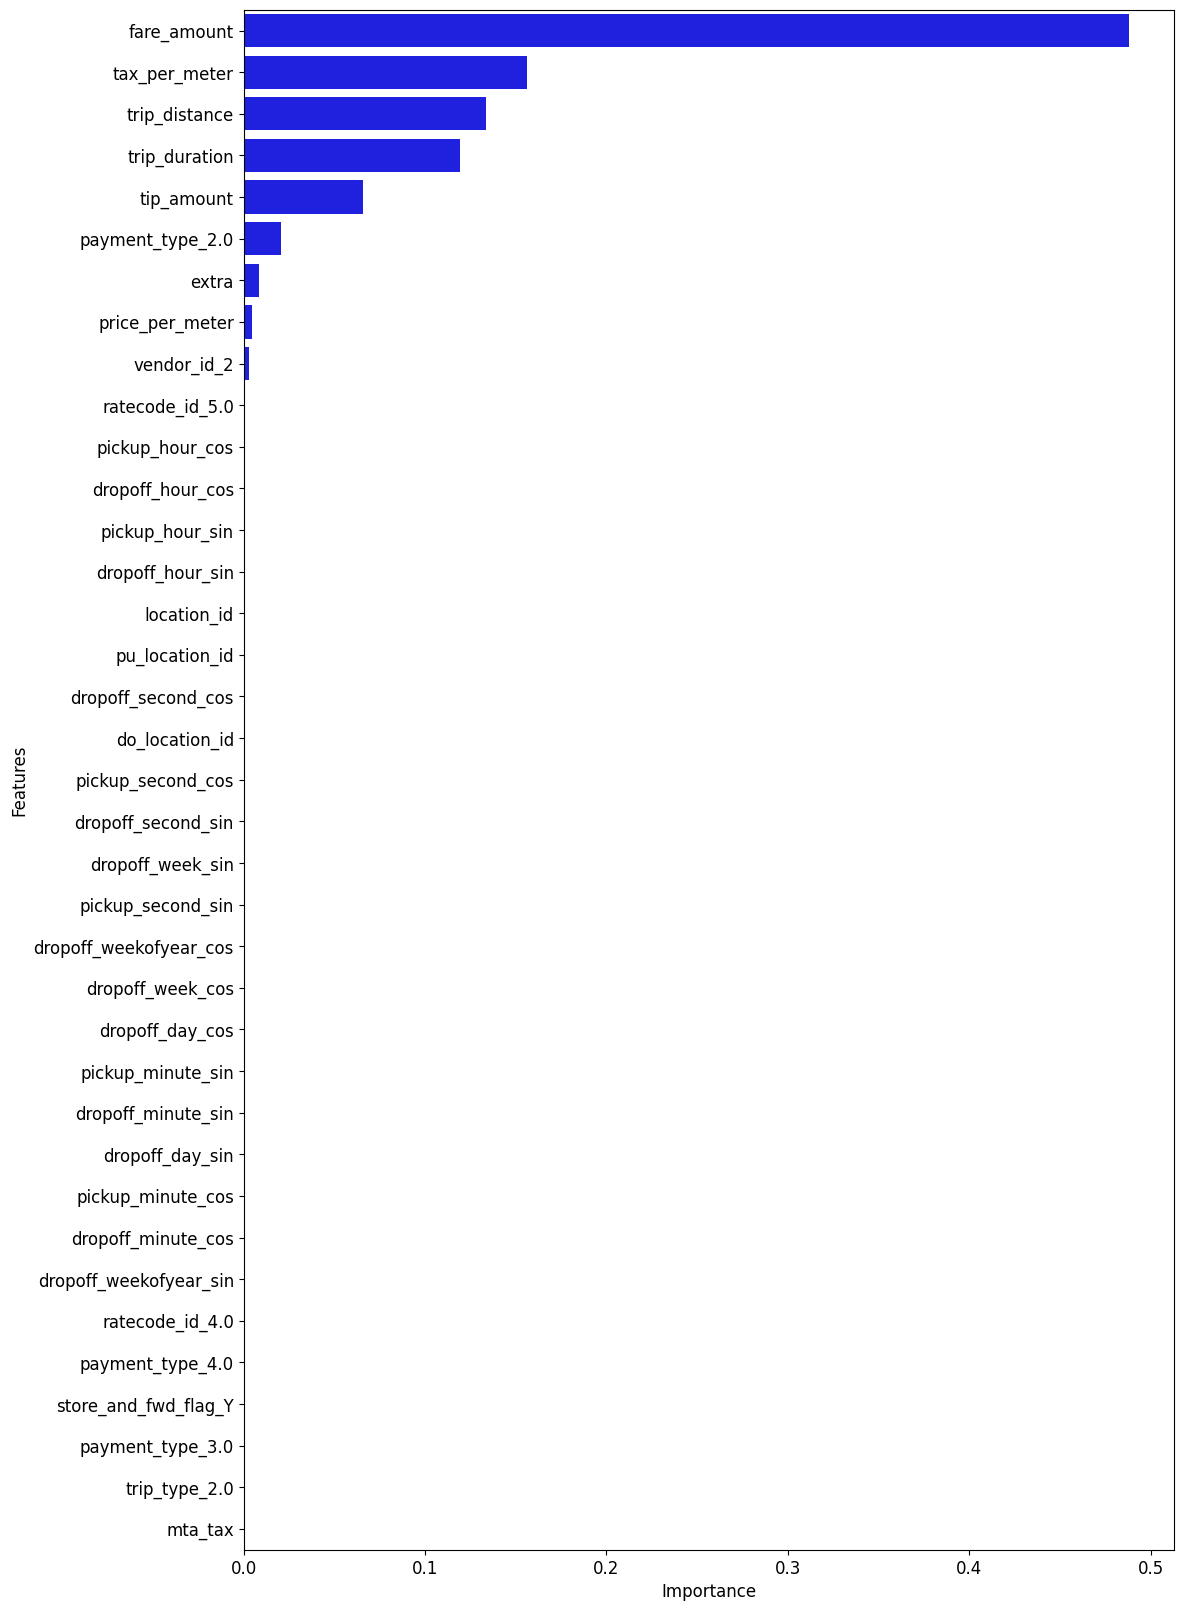

In [34]:
# Store feature importance into a dataframe and plot it
df_feature_importance = pd.DataFrame({
    "Features": X_train.drop("id", axis=1).columns,
    "Importance": xtrees_classifier.feature_importances_
}).sort_values(by="Importance", ascending=False) \
  .reset_index(drop=True)
plt.figure(figsize=(12,20))
sns.barplot(
    x="Importance",
    y="Features",
    data=df_feature_importance,
    orient="h",
    color='blue'
);

## 5.2. Wrapper

In [66]:
from boruta import BorutaPy
borutapy = BorutaPy(
    estimator=xtrees_classifier,
    n_estimators=100,
    verbose=1
).fit(X_train.drop("id", axis=1).to_numpy(), y_train.to_numpy())

Iteration: 1 / 100
Iteration: 2 / 100
Iteration: 3 / 100
Iteration: 4 / 100
Iteration: 5 / 100
Iteration: 6 / 100
Iteration: 7 / 100
Iteration: 8 / 100
Iteration: 9 / 100
Iteration: 10 / 100
Iteration: 11 / 100
Iteration: 12 / 100
Iteration: 13 / 100
Iteration: 14 / 100
Iteration: 15 / 100
Iteration: 16 / 100
Iteration: 17 / 100
Iteration: 18 / 100
Iteration: 19 / 100
Iteration: 20 / 100
Iteration: 21 / 100
Iteration: 22 / 100
Iteration: 23 / 100
Iteration: 24 / 100
Iteration: 25 / 100
Iteration: 26 / 100
Iteration: 27 / 100
Iteration: 28 / 100
Iteration: 29 / 100
Iteration: 30 / 100
Iteration: 31 / 100
Iteration: 32 / 100
Iteration: 33 / 100
Iteration: 34 / 100
Iteration: 35 / 100
Iteration: 36 / 100
Iteration: 37 / 100
Iteration: 38 / 100
Iteration: 39 / 100
Iteration: 40 / 100
Iteration: 41 / 100
Iteration: 42 / 100
Iteration: 43 / 100
Iteration: 44 / 100
Iteration: 45 / 100
Iteration: 46 / 100
Iteration: 47 / 100
Iteration: 48 / 100
Iteration: 49 / 100
Iteration: 50 / 100
Iteration

In [75]:
boruta_best_features: List[bool] = borutapy.support_.tolist()
selected_columns_by_boruta: List[str] = [
    column for column, is_selected, rank
    in zip(X_train.columns, boruta_best_features, borutapy.ranking_)
    if is_selected and rank == 1
]
print(selected_columns_by_boruta)

['do_location_id', 'trip_distance', 'fare_amount', 'mta_tax', 'tip_amount', 'location_id', 'price_per_meter', 'tax_per_meter', 'total_amount_per_extra', 'ratecode_id_4.0', 'ratecode_id_5.0', 'pickup_minute_cos', 'pickup_hour_sin', 'dropoff_minute_cos', 'dropoff_hour_sin']


## 5.3. Select columns

In [35]:
selected_columns: List[str] = [
    "id", "fare_amount", "trip_distance", "tax_per_meter",
    "trip_duration", "tip_amount", "payment_type_2.0"
]
X_train = X_train.loc[:, selected_columns]
X_val = X_val.loc[:, selected_columns]
X_train.sample(3)

,id,fare_amount,trip_distance,tax_per_meter,trip_duration,tip_amount,payment_type_2.0
22538,22539,-1.030251,-1.489081,-1.489081,-0.766438,0.510204,0
19366,19367,0.407987,0.581080,0.581080,0.545557,0.510204,0
4045,4046,1.966078,3.043123,3.043123,0.572442,0.000000,0


# 6. Machine learning modeling

## 6.1. Baseline

In [99]:
scores_dummy: List[float] = cross_validate(
    DummyRegressor(),
    X_train.drop("id", axis=1).to_numpy(),
    y_train.to_numpy(),
    scoring=(
        "neg_mean_absolute_error",
        "neg_root_mean_squared_error",
        "neg_mean_absolute_percentage_error"
    ),
    cv=10,
    n_jobs=(-1)
)
dummy_results: Dict[str, float] = get_metrics(scores_dummy)
print(dummy_results)

{'MAE': 3.60063, 'RMSE': 4.530897, 'MAPE': 0.36192}


## 6.2. Linear regression

In [74]:
scores_lr: List[float] = cross_validate(
    LinearRegression(),
    X_train.drop("id", axis=1).to_numpy(),
    y_train.to_numpy(),
    scoring=(
        "neg_mean_absolute_error",
        "neg_root_mean_squared_error",
        "neg_mean_absolute_percentage_error"
    ),
    cv=10,
    n_jobs=(-1)
)
lr_results: Dict[str, float] = get_metrics(scores_lr)
print(lr_results)

{'MAE': 0.36358, 'RMSE': 0.406571, 'MAPE': 0.036279}


## 6.3. KNeighborsRegressor

In [76]:
scores_knn: List[float] = cross_validate(
    KNeighborsRegressor(),
    X_train.drop("id", axis=1).to_numpy(),
    y_train.to_numpy(),
    scoring=(
        "neg_mean_absolute_error",
        "neg_root_mean_squared_error",
        "neg_mean_absolute_percentage_error"
    ),
    cv=10,
    n_jobs=(-1)
)
knn_results: Dict[str, float] = get_metrics(scores_knn)
print(knn_results)

{'MAE': 0.307128, 'RMSE': 0.425343, 'MAPE': 0.031081}


## 6.4. HistGradientBoostingRegressor

In [77]:
scores_hgb: List[float] = cross_validate(
    HistGradientBoostingRegressor(),
    X_train.drop("id", axis=1).to_numpy(),
    y_train.to_numpy(),
    scoring=(
        "neg_mean_absolute_error",
        "neg_root_mean_squared_error",
        "neg_mean_absolute_percentage_error"
    ),
    cv=10,
    n_jobs=(-1)
)
hgb_results: Dict[str, float] = get_metrics(scores_hgb)
print(hgb_results)

{'MAE': 0.299788, 'RMSE': 0.358642, 'MAPE': 0.030594}


## 6.5. LightGBMRegressor

In [80]:
scores_lgbm: List[float] = cross_validate(
    LGBMRegressor(),
    X_train.drop("id", axis=1).to_numpy(),
    y_train.to_numpy(),
    scoring=(
        "neg_mean_absolute_error",
        "neg_root_mean_squared_error",
        "neg_mean_absolute_percentage_error"
    ),
    cv=10,
    n_jobs=(-1)
)
lgbm_results: Dict[str, float] = get_metrics(scores_lgbm)
print(lgbm_results)

{'MAE': 0.296463, 'RMSE': 0.354873, 'MAPE': 0.030281}


## 6.6. XGBoostRegressor

In [81]:
scores_xgb: List[float] = cross_validate(
    XGBRegressor(),
    X_train.drop("id", axis=1).to_numpy(),
    y_train.to_numpy(),
    scoring=(
        "neg_mean_absolute_error",
        "neg_root_mean_squared_error",
        "neg_mean_absolute_percentage_error"
    ),
    cv=10,
    n_jobs=(-1)
)
xgb_results: Dict[str, float] = get_metrics(scores_xgb)
print(xgb_results)

{'MAE': 0.269187, 'RMSE': 0.341757, 'MAPE': 0.027771}


## 6.7. Compare models

In [95]:
df_model_comparison = pd.DataFrame(
    [
        dummy_results, lr_results, knn_results,
        hgb_results, lgbm_results, xgb_results
    ],
    columns=["MAE", "RMSE", "MAPE"],
    index=[
        "DummyRegressor",
        "LinearRegression",
        "KNeighborsRegressor",
        "HistGradientBoostingRegressor",
        "LightGBMRegressor",
        "XGBoostRegressor",
    ]
).sort_values(by="RMSE", ascending=True)
df_model_comparison

,MAE,RMSE,MAPE
XGBoostRegressor,0.269187,0.341757,0.027771
LightGBMRegressor,0.296463,0.354873,0.030281
HistGradientBoostingRegressor,0.299788,0.358642,0.030594
LinearRegression,0.363580,0.406571,0.036279
KNeighborsRegressor,0.307128,0.425343,0.031081
DummyRegressor,3.600630,4.530897,0.361920


<Axes: >

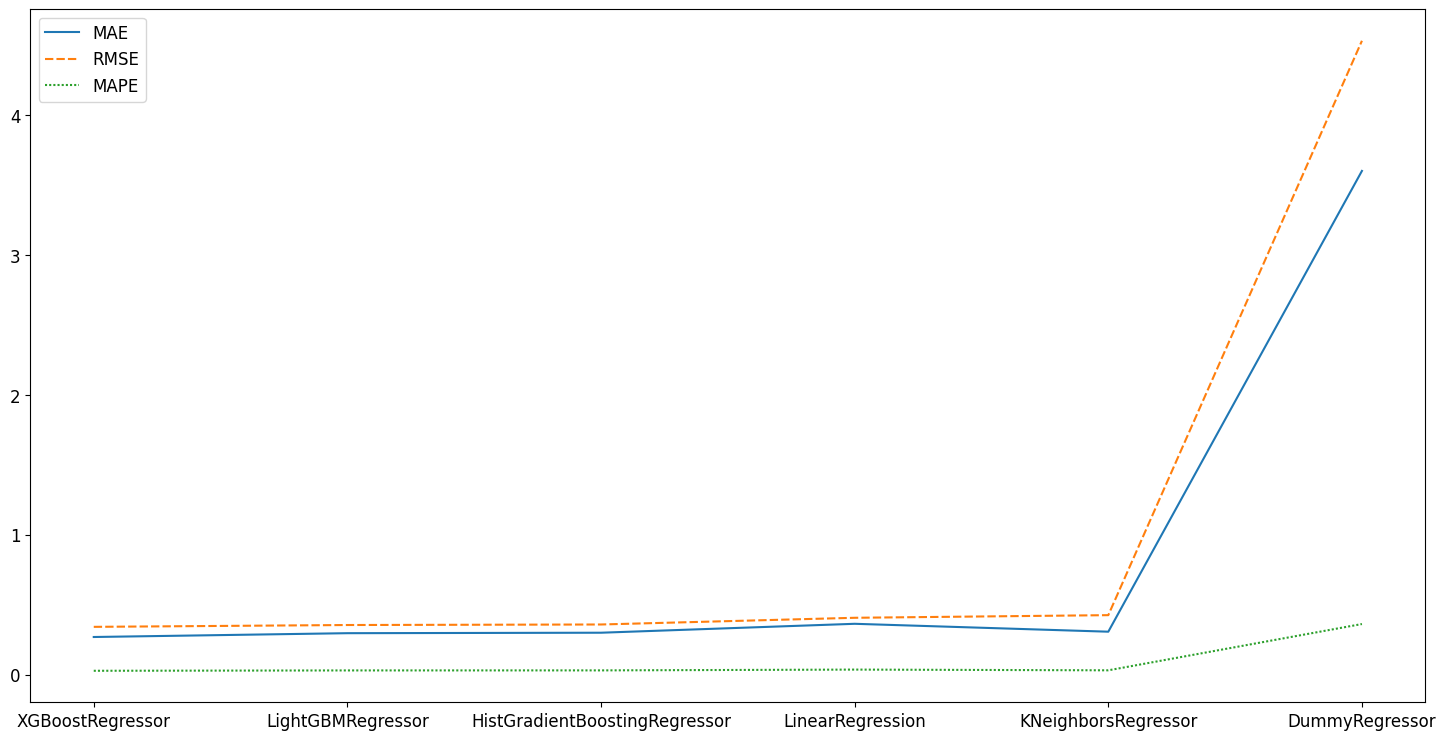

In [97]:
sns.lineplot(data=df_model_comparison)